In [ ]:
# Demonstartion of the physics and data informed aircraft dynamics model
# This covers the following:
# 1. Extracting trajectory data from a public database (FlightAware)
# 2. Analyzing the extracted data to detect flight phases and the following items of interest:
#    (a) detecting step climb during the cruise phase, and
#    (b) testing whether the aircraft was held at a constant altitude during descent
# 3. Demonstration of the composite aircraft dynamics model 
#    (a) Plotting the effective thrust force experienced by the aircraft]
#    (b) Evaluating model form errors during various flight phases

In [ ]:
# Inputs needed:
# valid FlightAware URL for a completed flight [eg. 'https://flightaware.com/live/flight/UAL1895/history/20200224/1225Z/KTPA/KIAH/tracklog']
# aircraft model number corresponding to this flight [eg. B739]
# ground level at the origin airport [eg. 26' at Tampa International Airport (KTPA)]

In [2]:
from fn_FlightAware_TrajData import pyfn_FlightAware_trajectory_extractor
from fn_flight_phases import pyfn_flight_phase
from fn_BADA_forces import pyfn_BADA_drag_thrust

import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load BADA data for aircraft models
filename2 = 'data_dictBADA_2'
with open(filename2, 'rb') as f:
    dictBADA_2 = pickle.load(f)


In [3]:
# Enter (a) a valid FlightAware URL [along witFA_URL],
# (b) aircraft model number [AC_model],
# and (c) ground level at origin airport, in ft. (GL_Origin)
FA_URL = 'https://flightaware.com/live/flight/UAL1895/history/20200224/1225Z/KTPA/KIAH/tracklog'
AC_model = 'B739'
GL_Origin = 26.


In [4]:
# Extract FlightAware trajectory from the specified URL
traj_mat, Time_s, Latitude, Longitude, Course_deg, TAS_kts, TAS_mph, Altitude_ft, ROCD = pyfn_FlightAware_trajectory_extractor(FA_URL)

In [5]:
# Analyze the extracted data
# (a) detect flight phases (climb, cruise, descent)
# (b) detect multiple altitude levels at cruise, if present (due to step climb),
# (c) check if the aircraft was held at a constant altitude during descent phase
Ix_ToC, Ix_ToD, time_cluster_all, alt_cluster_all, hold_descent_altitudes = pyfn_flight_phase(ROCD, Altitude_ft, Time_s)

# Note: Ignore the convergence warnings.

C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans.fit(temp2)
C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans.fit(temp2)
C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  kmeans.fit(temp2)
C:\Users\Abhinav\Documents\NASA_codes_for_paraATM\SectorwideRisk_module\fn_flight_phases.py:31: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  kmeans.fit(temp2)
C:\Users\Abhinav\Documents\NASA_

In [ ]:
# (b) If step climb was detected, plot multiple altitude levels at cruise
N_cruise_clusters = len(alt_cluster_all)
if N_cruise_clusters>1:    
    plot2 = plt.figure(2)
    for ix in range(N_cruise_clusters):
        plt.plot(time_cluster_all[ix],alt_cluster_all[ix])
    plt.xlabel('time (s)')
    plt.ylabel('altitude (ft)')
    plt.title('Cruise - Multiple flight levels')

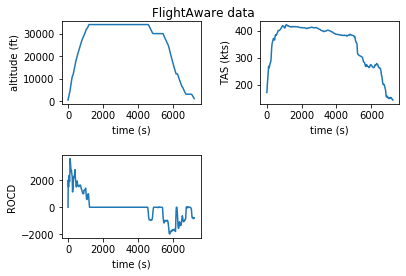

In [14]:
# (a) Plot formatted FlightAware trajectory
plot1 = plt.figure(1)
plt.subplot(2,2,1)
plt.plot(Time_s,Altitude_ft)
plt.xlabel('time (s)')
plt.ylabel('altitude (ft)')

plt.subplot(2,2,2)
plt.plot(Time_s,np.array(list(map(float,TAS_kts))))
plt.xlabel('time (s)')
plt.ylabel('TAS (kts)')

plt.subplot(2,2,3)
plt.plot(Time_s,ROCD)
plt.xlabel('time (s)')
plt.ylabel('ROCD')

plt.tight_layout(pad=2.0)
plt.suptitle('FlightAware data');

In [7]:
# Test whether the aircraft was held at a constant altitude during descent for a significant time duration (> 80 sec)
if hold_descent_altitudes.size>0:
    print('Aircraft was held at a constant level during descent at the following altitude(s) [Units: ft.]:')
    print(hold_descent_altitudes)


Aircraft was held at a constant level during descent at the following altitude(s):
[4360.71428571]


In [8]:
# Formulating the aircraft dynamics model
# Evaluating effective thrust experienced by the aircraft using Total Energy Model and FlightAware trajectory data
TAS_kts_float = np.array(list(map(float,TAS_kts)))
tas_rate = 0.514444*np.divide(TAS_kts_float[1:]-TAS_kts_float[:-1], Time_s[1:]-Time_s[:-1])
alt_rate = 0.3048*np.divide(Altitude_ft[1:]-Altitude_ft[:-1], Time_s[1:]-Time_s[:-1])

m = dictBADA_2[AC_model]['reference_mass']*1e3
g = 9.81;
v_tas = 0.514444*TAS_kts_float

eff_thrust = np.divide(m*g*alt_rate + m*np.multiply(v_tas[:-1],tas_rate),v_tas[:-1])

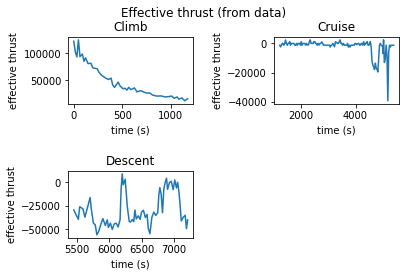

In [13]:
# Plot effective thrust computed from recorded flight data
plot3 = plt.figure(3)
plt.subplot(2,2,1)
plt.plot(Time_s[:Ix_ToC],eff_thrust[:Ix_ToC])
plt.xlabel('time (s)')
plt.ylabel('effective thrust')
plt.title('Climb')

plt.subplot(2,2,2)
plt.plot(Time_s[Ix_ToC+1:Ix_ToD-1],eff_thrust[Ix_ToC+1:Ix_ToD-1])
plt.xlabel('time (s)')
plt.ylabel('effective thrust')
plt.title('Cruise')

plt.subplot(2,2,3)
plt.plot(Time_s[Ix_ToD:-1],eff_thrust[Ix_ToD:])
plt.xlabel('time (s)')
plt.ylabel('effective thrust')
plt.title('Descent')

plt.tight_layout(pad=2.0)
plt.suptitle('Effective thrust (from data)');

In [10]:
# Compute Model Form Errors [as an additional Thrust force acting on the aircraft]
MFE_thrust = []

DragForce_climb = []
ThrustForce_climb = []
TimeAxis_climb = []
Effthrust_climb = []
for ix in range(0,Ix_ToC+1):
    h = Altitude_ft[ix]
    V_TAS = TAS_kts_float[ix]
    flight_phase = 1
    phi = 15
    DragForce_t, ThrustForce_t = pyfn_BADA_drag_thrust(h, V_TAS, flight_phase, phi, AC_model, GL_Origin)
    DragForce_climb.append(DragForce_t)
    ThrustForce_climb.append(ThrustForce_t)
    TimeAxis_climb.append(Time_s[ix])
    MFE_thrust.append(ThrustForce_t-DragForce_t-eff_thrust[ix])
    Effthrust_climb.append(eff_thrust[ix])

DragForce_cruise = []
ThrustForce_cruise = []
TimeAxis_cruise = []
Effthrust_cruise = []
for ix in range(Ix_ToC+1,Ix_ToD):
    h = Altitude_ft[ix]
    V_TAS = TAS_kts_float[ix]
    flight_phase = 2
    phi = 0
    DragForce_t, ThrustForce_t = pyfn_BADA_drag_thrust(h, V_TAS, flight_phase, phi, AC_model, GL_Origin)
    DragForce_cruise.append(DragForce_t)
    ThrustForce_cruise.append(ThrustForce_t)
    TimeAxis_cruise.append(Time_s[ix])
    MFE_thrust.append(0-eff_thrust[ix])
    Effthrust_cruise.append(eff_thrust[ix])
    
DragForce_descent = []
ThrustForce_descent = []
TimeAxis_descent = []
Effthrust_descent = []
for ix in range(Ix_ToD,eff_thrust.size):
    h = Altitude_ft[ix]
    V_TAS = TAS_kts_float[ix]
    flight_phase = 3
    phi = 15
    DragForce_t, ThrustForce_t = pyfn_BADA_drag_thrust(h, V_TAS, flight_phase, phi, AC_model, GL_Origin)
    DragForce_descent.append(DragForce_t)
    ThrustForce_descent.append(ThrustForce_t)
    TimeAxis_descent.append(Time_s[ix])
    MFE_thrust.append(ThrustForce_t-DragForce_t-eff_thrust[ix])
    Effthrust_descent.append(eff_thrust[ix])


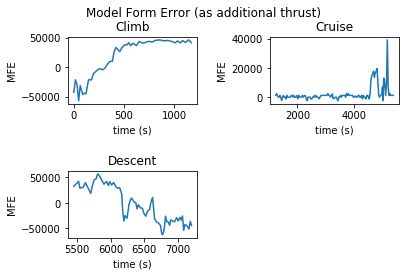

In [12]:
# Plot Model Form Errors
plot4 = plt.figure(4)
plt.subplot(2,2,1)
plt.plot(Time_s[:Ix_ToC],MFE_thrust[:Ix_ToC])
plt.xlabel('time (s)')
plt.ylabel('MFE')
plt.title('Climb')

plt.subplot(2,2,2)
plt.plot(Time_s[Ix_ToC+1:Ix_ToD-1],MFE_thrust[Ix_ToC+1:Ix_ToD-1])
plt.xlabel('time (s)')
plt.ylabel('MFE')
plt.title('Cruise')

plt.subplot(2,2,3)
plt.plot(Time_s[Ix_ToD:-1],MFE_thrust[Ix_ToD:])
plt.xlabel('time (s)')
plt.ylabel('MFE')
plt.title('Descent')

plt.tight_layout(pad=2.0)
plt.suptitle('Model Form Error (as additional thrust)');